In [1]:
import torch
import torch.nn.functional as F
import torchtext
import time
import pandas as pd

In [2]:
VOCABULARY_SIZE = 75000
LEARNING_RATE = 0.007
BATCH_SIZE = 125
NUM_EPOCHS = 25
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 125
HIDDEN_DIM = 250
NUM_CLASSES = 2

In [3]:
torch.device(0)

device(type='cuda', index=0)

In [5]:
#!pip install torchtext==0.9.1

In [6]:
#!python -m spacy download en_core_web_sm

In [4]:
### Defining the feature processing

TEXT = torchtext.legacy.data.Field(
    tokenize='spacy', # default splits on whitespace
    tokenizer_language='en_core_web_sm'
)

### Defining the label processing

LABEL = torchtext.legacy.data.LabelField(dtype=torch.long)

In [8]:
trainingDF = pd.read_csv("training_corpus.csv")
trainingDF = trainingDF.drop(columns=["Stemmed_Review_Text"])
trainingDF.head()

,Review_Text,isPos
0,comment limited generally first season 195960b...,1
1,writer ever happened baby jane hush hush sweet...,1
2,curious know critics responded rousing inspiri...,1
3,agree mr caruso jr lanzas finest voice god off...,1
4,movie fictional soap opera fast funny say anyt...,1


In [9]:
testingDF = pd.read_csv("testing_corpus.csv")
testingDF = testingDF.drop(columns=["Stemmed_Review_Text"])
testingDF.head()

,Review_Text,isPos
0,movie excellent save scenes esposito enjoyed b...,1
1,take look faces alongside entrance jail theyre...,1
2,wonderful story seen families story acting pro...,1
3,almost 4 years events 911 asked comes mind day...,1
4,pretty clever wellacted version modern 30s wom...,1


In [10]:
trainingDF.to_csv("pure_training.csv", index=False)
testingDF.to_csv("pure_testing.csv", index=False)

In [5]:
trainingDF = pd.read_csv("pure_testing.csv")
trainingDF.head()

,Review_Text,isPos
0,movie excellent save scenes esposito enjoyed b...,1
1,take look faces alongside entrance jail theyre...,1
2,wonderful story seen families story acting pro...,1
3,almost 4 years events 911 asked comes mind day...,1
4,pretty clever wellacted version modern 30s wom...,1


In [6]:
testingDF = pd.read_csv("pure_testing.csv")
testingDF.head()

,Review_Text,isPos
0,movie excellent save scenes esposito enjoyed b...,1
1,take look faces alongside entrance jail theyre...,1
2,wonderful story seen families story acting pro...,1
3,almost 4 years events 911 asked comes mind day...,1
4,pretty clever wellacted version modern 30s wom...,1


In [7]:
Fields = [("REVIEW_TEXT", TEXT), ("isPos", LABEL)]

train_dataset = torchtext.legacy.data.TabularDataset(path="pure_training.csv", format="csv", skip_header=True, fields=Fields)
test_dataset = torchtext.legacy.data.TabularDataset(path="pure_testing.csv", format="csv", skip_header=True, fields=Fields)

In [8]:
print(vars(train_dataset.examples[0]))

{'REVIEW_TEXT': ['movie', 'excellent', 'save', 'scenes', 'esposito', 'enjoyed', 'brought', 'together', 'every', 'detective', 'series', 'wrapped', 'plotlines', 'never', 'resolved', 'series', 'thanks', 'nbc', 'great', 'see', 'pembleton', 'bayliss', 'together', 'human', 'basic', 'persons', 'braugher', 'secor', 'great', 'job', 'usual', 'get', 'overlooked', 'hurt', 'see', 'end', 'homicide', 'memories', 'tapes', 'reruns', 'courttv', 'watching', 'come', 'every', 'friday', 'movie', 'job', 'well', 'presenting', 'great', 'depiction', 'life', 'al', 'retired', 'family', 'relationship', 'existed', 'unit', 'enjoyed', 'lot'], 'isPos': '1'}


In [8]:
TEXT.build_vocab(train_dataset, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_dataset)

print("Vocab size ", len(TEXT.vocab))
print("Num classes ", len(LABEL.vocab))

Vocab size  75002
Num classes  2


In [9]:
train_loader, test_loader = torchtext.legacy.data.BucketIterator.splits(
    (train_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    sort_within_batch=False,
    sort_key=lambda x: len(x.REVIEW_TEXT),
    device=torch.device(0)
)

In [10]:
for batch in train_loader:
    print("Matrix Size", batch.REVIEW_TEXT.size())
    print("Vector Size", batch.isPos.size())
    break

for batch in test_loader:
    print("Matrix Size", batch.REVIEW_TEXT.size())
    print("Vector Size", batch.isPos.size())
    break

Matrix Size torch.Size([1207, 125])
Vector Size torch.Size([125])
Matrix Size torch.Size([19, 125])
Vector Size torch.Size([125])


In [11]:
class RNN(torch.nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim)        
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, text):
        # text dim: [sentence length, batch size]
        
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        
        output = self.fc(hidden)
        return output

In [12]:
model = RNN(input_dim=len(TEXT.vocab),
            embedding_dim=125,
            hidden_dim=125,
            output_dim=2)

model = model.to(torch.device(0))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
            #print("Sum: ", (predicted_labels == targets).sum())
            #print("predicted_label: ", predicted_labels)
            #print("target: ", targets)
            
    f1 = f1_score(targets.cpu(), predicted_labels.cpu())
    rec = recall_score(targets.cpu(), predicted_labels.cpu())
    preci = precision_score(targets.cpu(), predicted_labels.cpu())

    print("f1: ", f1)
    print("recall: ", rec)
    print("precision: ", preci)
    return correct_pred.float()/num_examples * 100

In [14]:
start_time = time.time()
losses = []
for epoch in range(25):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        
        text = batch_data.REVIEW_TEXT.to(torch.device(0))
        labels = batch_data.isPos.to(torch.device(0))

        ### FORWARD AND BACK PROP
        logits = model(text)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        
        loss.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')
        
        if batch_idx == 199:
            losses.append(loss.item())
            print("\n")
            print("End Loss: ", loss.item())
            print("\n")

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, torch.device(0)):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, torch.device(0)):.2f}%')

Epoch: 001/025 | Batch 000/200 | Loss: 0.7048
Epoch: 001/025 | Batch 050/200 | Loss: 0.6910
Epoch: 001/025 | Batch 100/200 | Loss: 0.6925
Epoch: 001/025 | Batch 150/200 | Loss: 0.6928


End Loss:  0.6933398842811584




/home/null/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1:  0.0
recall:  0.0
precision:  0.0
training accuracy: 50.28%
Time elapsed: 0.24 min
Epoch: 002/025 | Batch 000/200 | Loss: 0.6960
Epoch: 002/025 | Batch 050/200 | Loss: 0.6970
Epoch: 002/025 | Batch 100/200 | Loss: 0.6918
Epoch: 002/025 | Batch 150/200 | Loss: 0.6942


End Loss:  0.6909477114677429


f1:  0.034482758620689655
recall:  0.017543859649122806
precision:  1.0
training accuracy: 50.31%
Time elapsed: 0.49 min
Epoch: 003/025 | Batch 000/200 | Loss: 0.6865
Epoch: 003/025 | Batch 050/200 | Loss: 0.6924
Epoch: 003/025 | Batch 100/200 | Loss: 0.6936
Epoch: 003/025 | Batch 150/200 | Loss: 0.6906


End Loss:  0.6892378330230713


f1:  0.6486486486486487
recall:  1.0
precision:  0.48
training accuracy: 50.24%
Time elapsed: 0.73 min
Epoch: 004/025 | Batch 000/200 | Loss: 0.6892
Epoch: 004/025 | Batch 050/200 | Loss: 0.6876
Epoch: 004/025 | Batch 100/200 | Loss: 0.6900
Epoch: 004/025 | Batch 150/200 | Loss: 0.6868


End Loss:  0.6878585815429688




/home/null/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1:  0.0
recall:  0.0
precision:  0.0
training accuracy: 50.37%
Time elapsed: 0.98 min
Epoch: 005/025 | Batch 000/200 | Loss: 0.6946
Epoch: 005/025 | Batch 050/200 | Loss: 0.6879
Epoch: 005/025 | Batch 100/200 | Loss: 0.6874
Epoch: 005/025 | Batch 150/200 | Loss: 0.6884


End Loss:  0.6904556751251221




/home/null/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1:  0.0
recall:  0.0
precision:  0.0
training accuracy: 50.36%
Time elapsed: 1.23 min
Epoch: 006/025 | Batch 000/200 | Loss: 0.6882
Epoch: 006/025 | Batch 050/200 | Loss: 0.6951
Epoch: 006/025 | Batch 100/200 | Loss: 0.6879
Epoch: 006/025 | Batch 150/200 | Loss: 0.6875


End Loss:  0.631508469581604


f1:  0.8421052631578948
recall:  0.972972972972973
precision:  0.7422680412371134
training accuracy: 66.85%
Time elapsed: 1.50 min
Epoch: 007/025 | Batch 000/200 | Loss: 0.6445
Epoch: 007/025 | Batch 050/200 | Loss: 0.5529
Epoch: 007/025 | Batch 100/200 | Loss: 0.5931
Epoch: 007/025 | Batch 150/200 | Loss: 0.5733


End Loss:  0.4200069010257721


f1:  0.8225806451612904
recall:  0.8793103448275862
precision:  0.7727272727272727
training accuracy: 81.22%
Time elapsed: 1.79 min
Epoch: 008/025 | Batch 000/200 | Loss: 0.4325
Epoch: 008/025 | Batch 050/200 | Loss: 0.3348
Epoch: 008/025 | Batch 100/200 | Loss: 0.3422
Epoch: 008/025 | Batch 150/200 | Loss: 0.3314


End Loss:  0.3384199440479278

In [15]:
import matplotlib.pyplot as plt

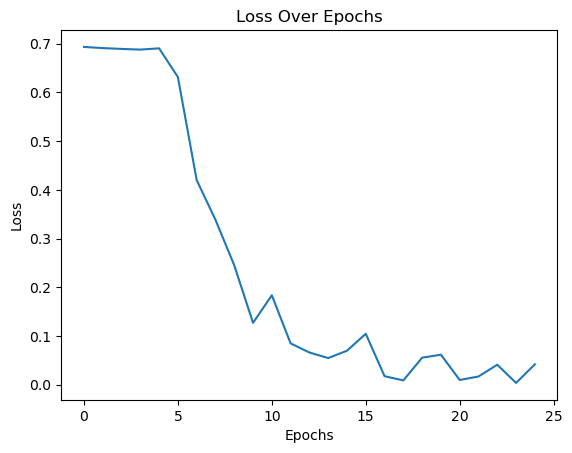

In [16]:
plt.plot(losses)
plt.title(label="Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show() 